In [1]:
# mrpcで事前学習済みのモデル
# パラフレーズ判定問題として定式化
# とりあえずheadはこちらで用意
# [CLS]トークンで予測

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='010'
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': False,  # bert cased なので
    }
    num_workers=4
    batch_size=12
    max_len=512

    # Model
    model="bert-base-cased-finetuned-mrpc"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sun Jun  5 09:17:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 5.6 MB/s 
CPU times: user 779 ms, sys: 143 ms, total: 922 ms
Wall time: 21.6 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,  # 'auto'
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 14.4 MB/s 
     |████████████████████████████████| 145 kB 58.6 MB/s 
     |████████████████████████████████| 181 kB 72.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

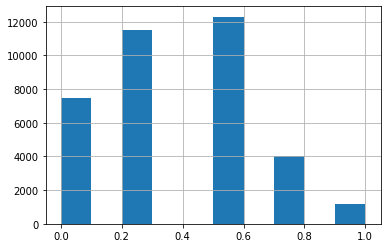

In [12]:
train['score'].hist()

In [13]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [14]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [15]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

# Dataset

In [17]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['context_text']) + \
              max(lengths_dict['target']) + max(lengths_dict['context_text']) + \
              3 # CLS + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 398


In [18]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, anchor, target):
    inputs = cfg.tokenizer(anchor, target,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.anchor_contexts = (df['anchor'] + ' ' + df['context_text']).values
        self.target_contexts = (df['target'] + ' ' + df['context_text']).values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.anchor_contexts[item], self.target_contexts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [19]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [22]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [23]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2257] Elapsed 0m 0s (remain 28m 50s) Loss: 0.6957(0.6957) Grad: 155139.5156  LR: 0.00002000  
Epoch: [1][100/2257] Elapsed 0m 52s (remain 18m 35s) Loss: 0.6100(0.6346) Grad: 94417.6875  LR: 0.00001999  
Epoch: [1][200/2257] Elapsed 1m 44s (remain 17m 44s) Loss: 0.4916(0.6184) Grad: 26942.8867  LR: 0.00001998  
Epoch: [1][300/2257] Elapsed 2m 35s (remain 16m 50s) Loss: 0.5451(0.6115) Grad: 37468.2891  LR: 0.00001995  
Epoch: [1][400/2257] Elapsed 3m 27s (remain 15m 58s) Loss: 0.5792(0.6063) Grad: 45737.2227  LR: 0.00001990  
Epoch: [1][500/2257] Elapsed 4m 18s (remain 15m 6s) Loss: 0.6769(0.6026) Grad: 24429.6914  LR: 0.00001985  
Epoch: [1][600/2257] Elapsed 5m 10s (remain 14m 14s) Loss: 0.8554(0.6027) Grad: 240844.6719  LR: 0.00001978  
Epoch: [1][700/2257] Elapsed 6m 1s (remain 13m 22s) Loss: 0.5470(0.5992) Grad: 30973.1934  LR: 0.00001970  
Epoch: [1][800/2257] Elapsed 6m 53s (remain 12m 30s) Loss: 0.6311(0.5966) Grad: 25714.0664  LR: 0.00001961  
Epoch: [1][900/2257] E

Epoch 1 - avg_train_loss: 0.5804  avg_val_loss: 0.5729  time: 1292s
Epoch 1 - Score: 0.7518


EVAL: [781/782] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7086(0.5729) 


Epoch 1 - Save Best Score: 0.7518 Model


Epoch: [2][0/2257] Elapsed 0m 0s (remain 28m 55s) Loss: 0.5958(0.5958) Grad: 65466.4336  LR: 0.00001707  
Epoch: [2][100/2257] Elapsed 0m 52s (remain 18m 43s) Loss: 0.4239(0.5337) Grad: 139763.5000  LR: 0.00001682  
Epoch: [2][200/2257] Elapsed 1m 44s (remain 17m 45s) Loss: 0.6274(0.5401) Grad: 45431.5312  LR: 0.00001656  
Epoch: [2][300/2257] Elapsed 2m 35s (remain 16m 51s) Loss: 0.4860(0.5405) Grad: 25639.1465  LR: 0.00001630  
Epoch: [2][400/2257] Elapsed 3m 27s (remain 15m 58s) Loss: 0.4649(0.5403) Grad: 96179.7812  LR: 0.00001602  
Epoch: [2][500/2257] Elapsed 4m 18s (remain 15m 6s) Loss: 0.4758(0.5407) Grad: 45250.6250  LR: 0.00001574  
Epoch: [2][600/2257] Elapsed 5m 10s (remain 14m 14s) Loss: 0.4527(0.5400) Grad: 62335.0781  LR: 0.00001545  
Epoch: [2][700/2257] Elapsed 6m 1s (remain 13m 22s) Loss: 0.6302(0.5380) Grad: 55607.5898  LR: 0.00001516  
Epoch: [2][800/2257] Elapsed 6m 53s (remain 12m 31s) Loss: 0.4385(0.5385) Grad: 125233.7578  LR: 0.00001486  
Epoch: [2][900/2257] E

Epoch 2 - avg_train_loss: 0.5362  avg_val_loss: 0.5731  time: 1294s
Epoch 2 - Score: 0.7616


EVAL: [781/782] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6961(0.5731) 


Epoch 2 - Save Best Score: 0.7616 Model


Epoch: [3][0/2257] Elapsed 0m 0s (remain 28m 10s) Loss: 0.5035(0.5035) Grad: 202129.0781  LR: 0.00001000  
Epoch: [3][100/2257] Elapsed 0m 52s (remain 18m 46s) Loss: 0.4289(0.5269) Grad: 96099.0469  LR: 0.00000965  
Epoch: [3][200/2257] Elapsed 1m 44s (remain 17m 46s) Loss: 0.5167(0.5248) Grad: 72052.1641  LR: 0.00000931  
Epoch: [3][300/2257] Elapsed 2m 35s (remain 16m 52s) Loss: 0.4983(0.5208) Grad: 122748.2734  LR: 0.00000896  
Epoch: [3][400/2257] Elapsed 3m 27s (remain 15m 59s) Loss: 0.4651(0.5210) Grad: 47720.8242  LR: 0.00000861  
Epoch: [3][500/2257] Elapsed 4m 18s (remain 15m 7s) Loss: 0.4099(0.5217) Grad: 47087.6641  LR: 0.00000827  
Epoch: [3][600/2257] Elapsed 5m 10s (remain 14m 15s) Loss: 0.5967(0.5195) Grad: 39460.2617  LR: 0.00000793  
Epoch: [3][700/2257] Elapsed 6m 1s (remain 13m 23s) Loss: 0.4110(0.5164) Grad: 42769.4766  LR: 0.00000759  
Epoch: [3][800/2257] Elapsed 6m 53s (remain 12m 31s) Loss: 0.4048(0.5181) Grad: 29753.1562  LR: 0.00000725  
Epoch: [3][900/2257] E

Epoch 3 - avg_train_loss: 0.5186  avg_val_loss: 0.5802  time: 1293s
Epoch 3 - Score: 0.7638


EVAL: [781/782] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7076(0.5802) 


Epoch 3 - Save Best Score: 0.7638 Model


Epoch: [4][0/2257] Elapsed 0m 0s (remain 28m 22s) Loss: 0.5259(0.5259) Grad: 121950.9453  LR: 0.00000293  
Epoch: [4][100/2257] Elapsed 0m 52s (remain 18m 46s) Loss: 0.4638(0.4981) Grad: 54725.6797  LR: 0.00000269  
Epoch: [4][200/2257] Elapsed 1m 44s (remain 17m 46s) Loss: 0.6370(0.5065) Grad: 154676.3281  LR: 0.00000246  
Epoch: [4][300/2257] Elapsed 2m 35s (remain 16m 52s) Loss: 0.6474(0.5075) Grad: 109265.1719  LR: 0.00000223  
Epoch: [4][400/2257] Elapsed 3m 27s (remain 15m 59s) Loss: 0.6366(0.5080) Grad: 44757.8633  LR: 0.00000202  
Epoch: [4][500/2257] Elapsed 4m 18s (remain 15m 7s) Loss: 0.5018(0.5066) Grad: 139498.0781  LR: 0.00000181  
Epoch: [4][600/2257] Elapsed 5m 10s (remain 14m 15s) Loss: 0.6231(0.5072) Grad: 53342.9062  LR: 0.00000162  
Epoch: [4][700/2257] Elapsed 6m 1s (remain 13m 23s) Loss: 0.3785(0.5060) Grad: 17865.7285  LR: 0.00000143  
Epoch: [4][800/2257] Elapsed 6m 53s (remain 12m 31s) Loss: 0.3676(0.5047) Grad: 83055.0078  LR: 0.00000126  
Epoch: [4][900/2257]

Epoch 4 - avg_train_loss: 0.5092  avg_val_loss: 0.5894  time: 1293s
Epoch 4 - Score: 0.7609


EVAL: [781/782] Elapsed 2m 9s (remain 0m 0s) Loss: 0.7050(0.5894) 


========== fold: 0 result ==========
Score: 0.7638
========== fold: 1 training ==========
Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2301] Elapsed 0m 0s (remain 27m 21s) Loss: 0.7011(0.7011) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2301] Elapsed 0m 52s (remain 19m 4s) Loss: 0.6141(0.6425) Grad: 72599.8516  LR: 0.00001999  
Epoch: [1][200/2301] Elapsed 1m 44s (remain 18m 8s) Loss: 0.6230(0.6313) Grad: 126958.8750  LR: 0.00001998  
Epoch: [1][300/2301] Elapsed 2m 35s (remain 17m 14s) Loss: 0.5265(0.6253) Grad: 46314.6328  LR: 0.00001995  
Epoch: [1][400/2301] Elapsed 3m 27s (remain 16m 21s) Loss: 0.6243(0.6189) Grad: 82395.6406  LR: 0.00001991  
Epoch: [1][500/2301] Elapsed 4m 18s (remain 15m 29s) Loss: 0.6308(0.6146) Grad: 87181.7578  LR: 0.00001985  
Epoch: [1][600/2301] Elapsed 5m 10s (remain 14m 37s) Loss: 0.3852(0.6095) Grad: 40213.0391  LR: 0.00001979  
Epoch: [1][700/2301] Elapsed 6m 1s (remain 13m 45s) Loss: 0.4670(0.6035) Grad: 60021.1367  LR: 0.00001972  
Epoch: [1][800/2301] Elapsed 6m 53s (remain 12m 54s) Loss: 0.4637(0.6002) Grad: 19244.9727  LR: 0.00001963  
Epoch: [1][900/2301] Elapsed 7m

Epoch 1 - avg_train_loss: 0.5789  avg_val_loss: 0.5752  time: 1309s
Epoch 1 - Score: 0.7308


EVAL: [738/739] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6985(0.5752) 


Epoch 1 - Save Best Score: 0.7308 Model


Epoch: [2][0/2301] Elapsed 0m 0s (remain 26m 51s) Loss: 0.3422(0.3422) Grad: inf  LR: 0.00001707  
Epoch: [2][100/2301] Elapsed 0m 52s (remain 19m 8s) Loss: 0.5275(0.5292) Grad: 73866.0625  LR: 0.00001682  
Epoch: [2][200/2301] Elapsed 1m 44s (remain 18m 8s) Loss: 0.6309(0.5375) Grad: 34963.0859  LR: 0.00001657  
Epoch: [2][300/2301] Elapsed 2m 35s (remain 17m 14s) Loss: 0.4881(0.5353) Grad: 73468.1719  LR: 0.00001631  
Epoch: [2][400/2301] Elapsed 3m 27s (remain 16m 22s) Loss: 0.6687(0.5345) Grad: 59126.1133  LR: 0.00001604  
Epoch: [2][500/2301] Elapsed 4m 18s (remain 15m 29s) Loss: 0.5145(0.5329) Grad: 54475.5977  LR: 0.00001576  
Epoch: [2][600/2301] Elapsed 5m 10s (remain 14m 37s) Loss: 0.5965(0.5317) Grad: 60453.2969  LR: 0.00001548  
Epoch: [2][700/2301] Elapsed 6m 1s (remain 13m 45s) Loss: 0.5589(0.5323) Grad: 67596.5547  LR: 0.00001519  
Epoch: [2][800/2301] Elapsed 6m 53s (remain 12m 54s) Loss: 0.5603(0.5315) Grad: 87295.1250  LR: 0.00001490  
Epoch: [2][900/2301] Elapsed 7m 

Epoch 2 - avg_train_loss: 0.5336  avg_val_loss: 0.5758  time: 1309s
Epoch 2 - Score: 0.7526


EVAL: [738/739] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6805(0.5758) 


Epoch 2 - Save Best Score: 0.7526 Model


Epoch: [3][0/2301] Elapsed 0m 0s (remain 29m 25s) Loss: 0.5095(0.5095) Grad: 120071.3047  LR: 0.00001000  
Epoch: [3][100/2301] Elapsed 0m 52s (remain 19m 8s) Loss: 0.4620(0.5239) Grad: 58538.6523  LR: 0.00000966  
Epoch: [3][200/2301] Elapsed 1m 44s (remain 18m 9s) Loss: 0.4610(0.5178) Grad: 28872.6621  LR: 0.00000931  
Epoch: [3][300/2301] Elapsed 2m 35s (remain 17m 15s) Loss: 0.4275(0.5188) Grad: 115254.8906  LR: 0.00000897  
Epoch: [3][400/2301] Elapsed 3m 27s (remain 16m 22s) Loss: 0.4874(0.5170) Grad: 72246.3516  LR: 0.00000864  
Epoch: [3][500/2301] Elapsed 4m 18s (remain 15m 30s) Loss: 0.4976(0.5173) Grad: 34654.9062  LR: 0.00000830  
Epoch: [3][600/2301] Elapsed 5m 10s (remain 14m 38s) Loss: 0.6079(0.5173) Grad: 55063.8125  LR: 0.00000796  
Epoch: [3][700/2301] Elapsed 6m 2s (remain 13m 46s) Loss: 0.5029(0.5171) Grad: 42789.0000  LR: 0.00000763  
Epoch: [3][800/2301] Elapsed 6m 53s (remain 12m 54s) Loss: 0.5775(0.5187) Grad: 40063.4766  LR: 0.00000730  
Epoch: [3][900/2301] El

Epoch 3 - avg_train_loss: 0.5174  avg_val_loss: 0.5933  time: 1309s
Epoch 3 - Score: 0.7528


EVAL: [738/739] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6900(0.5933) 


Epoch 3 - Save Best Score: 0.7528 Model


Epoch: [4][0/2301] Elapsed 0m 0s (remain 29m 8s) Loss: 0.4471(0.4471) Grad: 91532.5234  LR: 0.00000293  
Epoch: [4][100/2301] Elapsed 0m 52s (remain 19m 5s) Loss: 0.4342(0.5117) Grad: 35051.4766  LR: 0.00000269  
Epoch: [4][200/2301] Elapsed 1m 44s (remain 18m 9s) Loss: 0.5161(0.5039) Grad: 112708.3125  LR: 0.00000246  
Epoch: [4][300/2301] Elapsed 2m 35s (remain 17m 15s) Loss: 0.4669(0.5049) Grad: 41491.9609  LR: 0.00000224  
Epoch: [4][400/2301] Elapsed 3m 27s (remain 16m 22s) Loss: 0.5548(0.5047) Grad: 49539.5742  LR: 0.00000203  
Epoch: [4][500/2301] Elapsed 4m 18s (remain 15m 30s) Loss: 0.3518(0.5059) Grad: 120230.3047  LR: 0.00000183  
Epoch: [4][600/2301] Elapsed 5m 10s (remain 14m 38s) Loss: 0.4275(0.5072) Grad: 196246.6875  LR: 0.00000164  
Epoch: [4][700/2301] Elapsed 6m 2s (remain 13m 46s) Loss: 0.5174(0.5086) Grad: 51036.1641  LR: 0.00000145  
Epoch: [4][800/2301] Elapsed 6m 53s (remain 12m 54s) Loss: 0.4158(0.5086) Grad: 37713.4102  LR: 0.00000128  
Epoch: [4][900/2301] El

Epoch 4 - avg_train_loss: 0.5081  avg_val_loss: 0.5993  time: 1310s
Epoch 4 - Score: 0.7525


EVAL: [738/739] Elapsed 2m 2s (remain 0m 0s) Loss: 0.6805(0.5993) 


========== fold: 1 result ==========
Score: 0.7528
========== fold: 2 training ==========
Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2321] Elapsed 0m 0s (remain 28m 53s) Loss: 0.6828(0.6828) Grad: 92703.0859  LR: 0.00002000  
Epoch: [1][100/2321] Elapsed 0m 52s (remain 19m 17s) Loss: 0.6162(0.6386) Grad: 74817.7344  LR: 0.00001999  
Epoch: [1][200/2321] Elapsed 1m 44s (remain 18m 19s) Loss: 0.5715(0.6250) Grad: 64706.6367  LR: 0.00001998  
Epoch: [1][300/2321] Elapsed 2m 35s (remain 17m 26s) Loss: 0.4125(0.6151) Grad: 96001.0859  LR: 0.00001995  
Epoch: [1][400/2321] Elapsed 3m 27s (remain 16m 33s) Loss: 0.5416(0.6090) Grad: 49925.9062  LR: 0.00001991  
Epoch: [1][500/2321] Elapsed 4m 19s (remain 15m 41s) Loss: 0.6337(0.6067) Grad: 50000.6094  LR: 0.00001986  
Epoch: [1][600/2321] Elapsed 5m 10s (remain 14m 49s) Loss: 0.4752(0.6015) Grad: 76161.2656  LR: 0.00001979  
Epoch: [1][700/2321] Elapsed 6m 2s (remain 13m 57s) Loss: 0.6365(0.5999) Grad: 69354.9219  LR: 0.00001972  
Epoch: [1][800/2321] Elapsed 6m 53s (remain 13m 5s) Loss: 0.6487(0.5995) Grad: 162326.5469  LR: 0.00001964  
Epoch: [1][900/2321] El

Epoch 1 - avg_train_loss: 0.5809  avg_val_loss: 0.5615  time: 1318s
Epoch 1 - Score: 0.7565


EVAL: [717/718] Elapsed 1m 59s (remain 0m 0s) Loss: 0.5548(0.5615) 


Epoch 1 - Save Best Score: 0.7565 Model


Epoch: [2][0/2321] Elapsed 0m 0s (remain 29m 51s) Loss: 0.6154(0.6154) Grad: 102392.5625  LR: 0.00001707  
Epoch: [2][100/2321] Elapsed 0m 52s (remain 19m 20s) Loss: 0.5185(0.5516) Grad: 66444.2500  LR: 0.00001683  
Epoch: [2][200/2321] Elapsed 1m 44s (remain 18m 20s) Loss: 0.5690(0.5459) Grad: 28334.2109  LR: 0.00001658  
Epoch: [2][300/2321] Elapsed 2m 35s (remain 17m 26s) Loss: 0.4632(0.5420) Grad: 48368.4141  LR: 0.00001632  
Epoch: [2][400/2321] Elapsed 3m 27s (remain 16m 34s) Loss: 0.7892(0.5402) Grad: 191551.6406  LR: 0.00001605  
Epoch: [2][500/2321] Elapsed 4m 19s (remain 15m 42s) Loss: 0.5191(0.5412) Grad: 64929.2070  LR: 0.00001578  
Epoch: [2][600/2321] Elapsed 5m 10s (remain 14m 49s) Loss: 0.6589(0.5435) Grad: 45773.5781  LR: 0.00001550  
Epoch: [2][700/2321] Elapsed 6m 2s (remain 13m 57s) Loss: 0.5315(0.5439) Grad: 20177.9160  LR: 0.00001521  
Epoch: [2][800/2321] Elapsed 6m 54s (remain 13m 6s) Loss: 0.6617(0.5439) Grad: 107657.1797  LR: 0.00001492  
Epoch: [2][900/2321] 

Epoch 2 - avg_train_loss: 0.5417  avg_val_loss: 0.5578  time: 1319s
Epoch 2 - Score: 0.7721


EVAL: [717/718] Elapsed 1m 59s (remain 0m 0s) Loss: 0.5531(0.5578) 


Epoch 2 - Save Best Score: 0.7721 Model


Epoch: [3][0/2321] Elapsed 0m 0s (remain 28m 0s) Loss: 0.6167(0.6167) Grad: 91670.8984  LR: 0.00001000  
Epoch: [3][100/2321] Elapsed 0m 52s (remain 19m 18s) Loss: 0.5753(0.5196) Grad: 105066.6719  LR: 0.00000966  
Epoch: [3][200/2321] Elapsed 1m 44s (remain 18m 20s) Loss: 0.6761(0.5218) Grad: 76133.0469  LR: 0.00000933  
Epoch: [3][300/2321] Elapsed 2m 35s (remain 17m 26s) Loss: 0.4267(0.5223) Grad: 38252.6250  LR: 0.00000899  
Epoch: [3][400/2321] Elapsed 3m 27s (remain 16m 33s) Loss: 0.5997(0.5226) Grad: 111872.7031  LR: 0.00000865  
Epoch: [3][500/2321] Elapsed 4m 19s (remain 15m 41s) Loss: 0.5074(0.5212) Grad: 21582.5195  LR: 0.00000832  
Epoch: [3][600/2321] Elapsed 5m 10s (remain 14m 49s) Loss: 0.5567(0.5220) Grad: 29766.1836  LR: 0.00000799  
Epoch: [3][700/2321] Elapsed 6m 2s (remain 13m 57s) Loss: 0.4788(0.5219) Grad: 34163.2070  LR: 0.00000766  
Epoch: [3][800/2321] Elapsed 6m 53s (remain 13m 5s) Loss: 0.5398(0.5227) Grad: 114269.7969  LR: 0.00000733  
Epoch: [3][900/2321] E

Epoch 3 - avg_train_loss: 0.5224  avg_val_loss: 0.5693  time: 1318s
Epoch 3 - Score: 0.7715


EVAL: [717/718] Elapsed 1m 59s (remain 0m 0s) Loss: 0.5195(0.5693) 
Epoch: [4][0/2321] Elapsed 0m 0s (remain 31m 40s) Loss: 0.5063(0.5063) Grad: 71691.2031  LR: 0.00000293  
Epoch: [4][100/2321] Elapsed 0m 52s (remain 19m 16s) Loss: 0.6260(0.5100) Grad: 71464.0000  LR: 0.00000270  
Epoch: [4][200/2321] Elapsed 1m 44s (remain 18m 19s) Loss: 0.4574(0.5195) Grad: 52611.7500  LR: 0.00000247  
Epoch: [4][300/2321] Elapsed 2m 35s (remain 17m 25s) Loss: 0.6332(0.5186) Grad: 165204.6406  LR: 0.00000225  
Epoch: [4][400/2321] Elapsed 3m 27s (remain 16m 32s) Loss: 0.6267(0.5168) Grad: 38127.5391  LR: 0.00000204  
Epoch: [4][500/2321] Elapsed 4m 19s (remain 15m 41s) Loss: 0.7564(0.5170) Grad: 550566.3750  LR: 0.00000184  
Epoch: [4][600/2321] Elapsed 5m 10s (remain 14m 49s) Loss: 0.4807(0.5175) Grad: 256062.8750  LR: 0.00000165  
Epoch: [4][700/2321] Elapsed 6m 2s (remain 13m 57s) Loss: 0.3456(0.5153) Grad: 31457.5352  LR: 0.00000147  
Epoch: [4][800/2321] Elapsed 6m 53s (remain 13m 5s) Loss: 0.5

Epoch 4 - avg_train_loss: 0.5127  avg_val_loss: 0.5733  time: 1318s
Epoch 4 - Score: 0.7703


EVAL: [717/718] Elapsed 1m 59s (remain 0m 0s) Loss: 0.5196(0.5733) 


========== fold: 2 result ==========
Score: 0.7721
========== fold: 3 training ==========
Some weights of the model checkpoint at bert-base-cased-finetuned-mrpc were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2237] Elapsed 0m 0s (remain 27m 55s) Loss: 0.6569(0.6569) Grad: 157873.9531  LR: 0.00002000  
Epoch: [1][100/2237] Elapsed 0m 52s (remain 18m 37s) Loss: 0.6152(0.6457) Grad: 123174.4141  LR: 0.00001999  
Epoch: [1][200/2237] Elapsed 1m 44s (remain 17m 37s) Loss: 0.5979(0.6281) Grad: 77541.7812  LR: 0.00001998  
Epoch: [1][300/2237] Elapsed 2m 36s (remain 16m 43s) Loss: 0.4965(0.6205) Grad: 82778.8594  LR: 0.00001994  
Epoch: [1][400/2237] Elapsed 3m 27s (remain 15m 50s) Loss: 0.6496(0.6147) Grad: 71435.3594  LR: 0.00001990  
Epoch: [1][500/2237] Elapsed 4m 19s (remain 14m 58s) Loss: 0.5661(0.6103) Grad: 41925.8164  LR: 0.00001985  
Epoch: [1][600/2237] Elapsed 5m 10s (remain 14m 6s) Loss: 0.6266(0.6068) Grad: 41212.1289  LR: 0.00001978  
Epoch: [1][700/2237] Elapsed 6m 2s (remain 13m 14s) Loss: 0.6132(0.6029) Grad: 57437.7070  LR: 0.00001970  
Epoch: [1][800/2237] Elapsed 6m 54s (remain 12m 22s) Loss: 0.5790(0.5994) Grad: 63259.3516  LR: 0.00001961  
Epoch: [1][900/2237] E

Epoch 1 - avg_train_loss: 0.5808  avg_val_loss: 0.5777  time: 1289s
Epoch 1 - Score: 0.7332
Epoch 1 - Save Best Score: 0.7332 Model


Epoch: [2][0/2237] Elapsed 0m 0s (remain 28m 12s) Loss: 0.6759(0.6759) Grad: 87751.2266  LR: 0.00001707  
Epoch: [2][100/2237] Elapsed 0m 52s (remain 18m 39s) Loss: 0.5548(0.5461) Grad: 75102.7344  LR: 0.00001682  
Epoch: [2][200/2237] Elapsed 1m 44s (remain 17m 38s) Loss: 0.5127(0.5367) Grad: 74099.8359  LR: 0.00001656  
Epoch: [2][300/2237] Elapsed 2m 36s (remain 16m 44s) Loss: 0.5436(0.5399) Grad: 92894.4766  LR: 0.00001629  
Epoch: [2][400/2237] Elapsed 3m 27s (remain 15m 51s) Loss: 0.6690(0.5368) Grad: 47744.5000  LR: 0.00001601  
Epoch: [2][500/2237] Elapsed 4m 19s (remain 14m 59s) Loss: 0.6594(0.5406) Grad: 77218.3594  LR: 0.00001573  
Epoch: [2][600/2237] Elapsed 5m 11s (remain 14m 6s) Loss: 0.4954(0.5403) Grad: 39997.1680  LR: 0.00001544  
Epoch: [2][700/2237] Elapsed 6m 2s (remain 13m 14s) Loss: 0.4720(0.5406) Grad: 59983.4883  LR: 0.00001514  
Epoch: [2][800/2237] Elapsed 6m 54s (remain 12m 22s) Loss: 0.5409(0.5401) Grad: 50652.2266  LR: 0.00001483  
Epoch: [2][900/2237] Ela

Epoch 2 - avg_train_loss: 0.5405  avg_val_loss: 0.5792  time: 1289s
Epoch 2 - Score: 0.7418
Epoch 2 - Save Best Score: 0.7418 Model


Epoch: [3][0/2237] Elapsed 0m 0s (remain 26m 58s) Loss: 0.5582(0.5582) Grad: 62231.0938  LR: 0.00001000  
Epoch: [3][100/2237] Elapsed 0m 52s (remain 18m 35s) Loss: 0.5106(0.5213) Grad: 128637.4688  LR: 0.00000965  
Epoch: [3][200/2237] Elapsed 1m 44s (remain 17m 37s) Loss: 0.5660(0.5224) Grad: 54298.0117  LR: 0.00000930  
Epoch: [3][300/2237] Elapsed 2m 35s (remain 16m 43s) Loss: 0.5722(0.5237) Grad: 86851.7422  LR: 0.00000895  
Epoch: [3][400/2237] Elapsed 3m 27s (remain 15m 50s) Loss: 0.6398(0.5231) Grad: 33798.1797  LR: 0.00000860  
Epoch: [3][500/2237] Elapsed 4m 19s (remain 14m 57s) Loss: 0.5573(0.5244) Grad: 56384.4688  LR: 0.00000825  
Epoch: [3][600/2237] Elapsed 5m 10s (remain 14m 5s) Loss: 0.6752(0.5213) Grad: 109269.1172  LR: 0.00000791  
Epoch: [3][700/2237] Elapsed 6m 2s (remain 13m 14s) Loss: 0.4745(0.5221) Grad: 106052.6719  LR: 0.00000757  
Epoch: [3][800/2237] Elapsed 6m 53s (remain 12m 22s) Loss: 0.6447(0.5227) Grad: 117346.5234  LR: 0.00000723  
Epoch: [3][900/2237]

Epoch 3 - avg_train_loss: 0.5209  avg_val_loss: 0.5959  time: 1289s
Epoch 3 - Score: 0.7411


Epoch: [4][0/2237] Elapsed 0m 0s (remain 28m 4s) Loss: 0.5572(0.5572) Grad: 169735.9531  LR: 0.00000293  
Epoch: [4][100/2237] Elapsed 0m 52s (remain 18m 35s) Loss: 0.5332(0.5101) Grad: 48908.5078  LR: 0.00000269  
Epoch: [4][200/2237] Elapsed 1m 44s (remain 17m 36s) Loss: 0.6099(0.5047) Grad: 20469.2734  LR: 0.00000245  
Epoch: [4][300/2237] Elapsed 2m 35s (remain 16m 42s) Loss: 0.5093(0.5136) Grad: 71595.0781  LR: 0.00000223  
Epoch: [4][400/2237] Elapsed 3m 27s (remain 15m 49s) Loss: 0.4963(0.5107) Grad: 55807.2188  LR: 0.00000201  
Epoch: [4][500/2237] Elapsed 4m 19s (remain 14m 57s) Loss: 0.4524(0.5107) Grad: 53045.2109  LR: 0.00000180  
Epoch: [4][600/2237] Elapsed 5m 10s (remain 14m 5s) Loss: 0.6077(0.5099) Grad: 37609.2109  LR: 0.00000161  
Epoch: [4][700/2237] Elapsed 6m 2s (remain 13m 13s) Loss: 0.6183(0.5100) Grad: 44056.3945  LR: 0.00000142  
Epoch: [4][800/2237] Elapsed 6m 53s (remain 12m 22s) Loss: 0.5066(0.5107) Grad: 69725.0625  LR: 0.00000125  
Epoch: [4][900/2237] Ela

Epoch 4 - avg_train_loss: 0.5107  avg_val_loss: 0.5976  time: 1289s
Epoch 4 - Score: 0.7423
Epoch 4 - Save Best Score: 0.7423 Model
========== fold: 3 result ==========
Score: 0.7423
========== CV ==========
Score: 0.7563


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▁▄█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▇▅▇▂▆▆▄▅▇▆▃▅▇▄▄█▃▆▅▃▆█▄▅▃▇▄▄▇▇█▄▃▁▄▅▅▄
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇█▆
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▁▆█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▃▆▇▆█▆▅▄▃▅▄▄▅▁▅▃▆▅▆▅▃▂▅▆▄▁▄▆▄▂▃▄▅▅▄▄▅▂▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [24]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.32k/2.32k [00:01<00:00, 1.28kB/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:02<00:00, 6.13kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 870k/870k [00:01<00:00, 493kB/s]
Upload successful: tokenizer.tar (870KB)
Starting upload for file config.pth
100% 2.23k/2.23k [00:01<00:00, 1.31kB/s]
Upload successful: config.pth (2KB)
Starting upload for file bert-base-cased-finetuned-mrpc_fold0_best.pth
100% 415M/415M [00:12<00:00, 35.0MB/s]
Upload successful: bert-base-cased-finetuned-mrpc_fold0_best.pth (415MB)
Starting upload for file bert-base-cased-finetuned-mrpc_fold1_best.pth
100% 415M/415M [00:14<00:00, 30.8MB/s]
Upload successful: bert-base-cased-finetuned-mrpc_fold1_best.pth (415MB)
Starting upload for file bert-base-cased-finetuned-mrpc_fold2_best.pth
100% 415M/415M [00:13<00:00, 31.6MB/s]
Upload successful: bert-base-cased-finetuned-mrpc_fold2_best.p